In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import curve_fit

#Use better looking plot settings
plt.rc('font',family='serif')

In [2]:
## Code here or write here
## Read in the advertising data
RootData = pd.read_csv("Root_Insurance_data.csv")

## Make a train test split, setting aside 25% of the data as a test for later
#RootData_train = RootData.copy().sample(frac=.75,random_state = 23)
#RootData_test = RootData.copy().drop(RootData.index)

#Actually don't think we need these yet

In [3]:
RootData

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,N,1,2,S,10.0,3,True,0
9996,unknown,3,2,M,10.0,3,False,0
9997,Y,3,1,S,10.0,5,False,0
9998,unknown,3,1,M,10.0,3,False,0


In [4]:
def basic_info(Category=None, Value=None, RankNum=0, printout=True):
    # Find the clicks per ad, policies sold per ad, and policies sold per click for a subset of the data
    # Return these values, along with their associated uncertainties
    
    if Category==None: #get all the data without cutting on a condition
        ad_clicks = len( RootData.loc[RootData["click"]==True] )
        policies_sold = len( RootData.loc[RootData["policies_sold"]==1] )
        total_ads = len(RootData)
        print(total_ads,'total ads')
        print(ad_clicks,'ad clicks')
        print(policies_sold,'policies sold')
    elif RankNum == 0: #look at only the data specified by the Category and its Value
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[RootData[Category]==Value])
    else: #look at only the data specified by the Category and its Value for rank=RankNum
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[(RootData["rank"]==RankNum) & (RootData[Category]==Value)])
    
    #print(ad_clicks,'ad clicks')
    #print(policies_sold,'policies sold')
    #print(total_ads,'total ads')
    
    if total_ads > 0:
        clicks_per_ad = ad_clicks/total_ads
        policies_per_ad = policies_sold/total_ads
        policies_per_click = policies_per_ad/clicks_per_ad
        err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
    else:
        return ['---', '---', '---', '---', '---', '---']
    
    if printout == True:
        #print(ad_clicks,'ad clicks')
        #print(policies_sold,'policies sold')
        #print(total_ads,'total ads')
        print(round(clicks_per_ad,3),'+/-',round(err_clicks_per_ad,4),'clicks per ad')
        print(round(policies_per_ad,3),'+/-',round(err_policies_per_ad,4),'policies sold per ad')
        print(round(policies_per_click,3),'+/-',round(err_policies_per_click,4),'policies sold per click')
    
    return [clicks_per_ad, err_clicks_per_ad, policies_per_ad, err_policies_per_ad, policies_per_click, err_policies_per_click]

In [10]:
insured_vals = list( set(RootData["Currently Insured"]) )
vehicles_vals = list( set(RootData["Number of Vehicles"]) )
drivers_vals = list( set(RootData["Number of Drivers"]) )
marital_vals = list( set(RootData["Marital Status"]) )

categories_df = pd.DataFrame({
                        'Insured':[],
                        'Vehicles':[],
                        'Drivers':[],
                        'Marital Status':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                        'Total Clicks':[],
                        'Total Click Uncertainty':[],
                        'Total Policies Sold':[],
                        'Total Policies Sold Uncertainty':[],
                        'Expected Policies Sold at Rank 5':[],
                        'Uncertainty in Rank 5 Sales Estimate':[],
                        'Expected Clicks per Ad':[],
                        'AvgRank':[],
                        'Rank1':[],
                        'Rank2':[],
                        'Rank3':[],
                        'Rank4':[],
                        'Rank5':[]
                        })

#Will need the expected clicks per ad for an ad displayed in ranks 1-5
R1ExpClickPA = basic_info("rank",1,printout=False)[0]
R1ErrClickPa = basic_info("rank",1,printout=False)[1]
R2ExpClickPA = basic_info("rank",2,printout=False)[0]
R2ErrClickPa = basic_info("rank",2,printout=False)[1]
R3ExpClickPA = basic_info("rank",3,printout=False)[0]
R3ErrClickPa = basic_info("rank",3,printout=False)[1]
R4ExpClickPA = basic_info("rank",4,printout=False)[0]
R4ErrClickPa = basic_info("rank",4,printout=False)[1]
R5ExpClickPA = basic_info("rank",5,printout=False)[0]
R5ErrClickPa = basic_info("rank",5,printout=False)[1]

for insured_val in insured_vals:
    for vehicles_val in vehicles_vals:
        for drivers_val in drivers_vals:
            for marital_val in marital_vals:
                Ranks = [ len(RootData.loc[(RootData["rank"]==i+1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)]) for i in range(5) ]
                ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                total_ads = len(RootData.loc[(RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                if (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4]) > 0:
                    #probably best to just leave out the empty unknown/3/2/S bin that has no ads
                    #which is what this if statement does
                    
                    clicks_per_ad = ad_clicks/total_ads
                    policies_per_ad = policies_sold/total_ads
                    policies_per_click = policies_per_ad/clicks_per_ad
                    
                    err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
                    
                    ExpClickTot = R1ExpClickPA*Ranks[0] + R2ExpClickPA*Ranks[1] + R3ExpClickPA*Ranks[2] + R4ExpClickPA*Ranks[3] + R5ExpClickPA*Ranks[4]
                    AvgRank = ( 1*Ranks[0]+2*Ranks[1]+3*Ranks[2]+4*Ranks[3]+5*Ranks[4] ) / (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ExpClickperAd = ExpClickTot/sum(Ranks)
                    
                    #Number of expected clicks if we were to place all ads for customers of these traits in rank 5
                    ExpClickR5 = R5ExpClickPA*(Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ErrClickR5 = ExpClickR5*np.sqrt(R5ErrClickPa**2)
                    ExpPoliciesR5 = policies_per_click*ExpClickR5
                    ErrPoliciesR5 = ExpPoliciesR5 * np.sqrt( (err_policies_per_click/policies_per_click)**2 + (ErrClickR5/ExpClickR5)**2 )
                    
                    #print(insured_val, vehicles_val, drivers_val, marital_val, AvgRank_Val, policies_per_click)
                    new_row = {'Insured':insured_val, 'Vehicles':vehicles_val, 'Drivers':drivers_val,
                               'Marital Status':marital_val, 'Policies Sold per Click':policies_per_click,
                               'Policies Sold per Click Uncertainty':err_policies_per_click,
                               'Total Clicks':ad_clicks, 'Total Click Uncertainty':np.sqrt(ad_clicks),
                               'Total Policies Sold':policies_sold, 'Total Policies Sold Uncertainty':np.sqrt(policies_sold),
                               'Expected Policies Sold at Rank 5':ExpPoliciesR5,'Uncertainty in Rank 5 Sales Estimate':ErrPoliciesR5,
                               'Expected Clicks per Ad':ExpClickperAd, 'AvgRank':AvgRank,
                               'Rank1':Ranks[0],'Rank2':Ranks[1], 'Rank3':Ranks[2],'Rank4':Ranks[3], 'Rank5':Ranks[4]
                               }
                    categories_df = categories_df.append(new_row, ignore_index=True)

categories_df = categories_df.sort_values(by=['Policies Sold per Click'], ascending=False).reset_index(drop=True)
categories_df


,Insured,Vehicles,Drivers,Marital Status,Policies Sold per Click,Policies Sold per Click Uncertainty,Total Clicks,Total Click Uncertainty,Total Policies Sold,Total Policies Sold Uncertainty,Expected Policies Sold at Rank 5,Uncertainty in Rank 5 Sales Estimate,Expected Clicks per Ad,AvgRank,Rank1,Rank2,Rank3,Rank4,Rank5
0,N,3.0,1.0,M,0.600000,0.258296,15.0,3.872983,9.0,3.000000,3.400698,1.464017,0.063673,4.305660,0.0,0.0,51.0,82.0,132.0
1,N,1.0,1.0,S,0.581395,0.154520,43.0,6.557439,25.0,5.000000,3.369860,0.895682,0.135176,3.435424,0.0,59.0,84.0,79.0,49.0
2,N,1.0,1.0,M,0.560000,0.192444,25.0,5.000000,14.0,3.741657,3.593191,1.234849,0.123254,3.573333,0.0,53.0,87.0,95.0,65.0
3,unknown,1.0,1.0,S,0.543307,0.093331,127.0,11.269428,69.0,8.306624,3.253677,0.559019,0.392509,1.621429,148.0,90.0,42.0,0.0,0.0
4,unknown,1.0,2.0,M,0.542857,0.099907,105.0,10.246951,57.0,7.549834,3.413531,0.628312,0.386952,1.659864,155.0,84.0,55.0,0.0,0.0
5,unknown,1.0,1.0,M,0.526786,0.095231,112.0,10.583005,59.0,7.681146,3.312473,0.598907,0.380966,1.690476,150.0,85.0,59.0,0.0,0.0
6,N,3.0,2.0,M,0.523810,0.199229,21.0,4.582576,11.0,3.316625,3.652262,1.389169,0.067401,4.245399,0.0,0.0,71.0,104.0,151.0
7,unknown,2.0,1.0,M,0.488095,0.102101,84.0,9.165151,41.0,6.403124,2.797759,0.585309,0.365601,1.761194,122.0,88.0,58.0,0.0,0.0
8,Y,1.0,1.0,S,0.487179,0.104526,78.0,8.831761,38.0,6.164414,3.021746,0.648391,0.246573,2.548276,60.0,74.0,93.0,63.0,0.0
9,N,2.0,2.0,S,0.468750,0.151346,32.0,5.656854,15.0,3.872983,3.168103,1.022936,0.117588,3.632911,0.0,48.0,94.0,100.0,74.0


In [288]:
#This is the amount (in dollars) that we are assuming will increase a bid's rank placement by 1 spot
RankValue = 2.50

# We'll again assume that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01

PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])


In [289]:
def UpdatedBidInfo(cat_ind, NewBid, printout=True):
    #Figure out how ad clicks and subsequent policy sales change when the $10 bid is changed to NewBid
    #This assumes that increasing a bid by RankValue will shift the ad up one rank
    
    i = cat_ind #the index of the entry in categories_df
    
    if NewBid == 10.00+4.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank1s +=categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank5"]
        Rank2s = 0
        Rank3s = 0
        Rank4s = 0
        Rank5s = 0
    elif NewBid == 10.00+3.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank1s +=categories_df.iloc[i]["Rank4"]
        Rank2s = categories_df.iloc[i]["Rank5"]
        Rank3s = 0
        Rank4s = 0
        Rank5s = 0
    elif NewBid == 10.00+2.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank3"]
        Rank2s = categories_df.iloc[i]["Rank4"]
        Rank3s = categories_df.iloc[i]["Rank5"]
        Rank4s = 0
        Rank5s = 0
    elif NewBid == 10.00+1.0*RankValue:
        Rank1s = categories_df.iloc[i]["Rank1"]+categories_df.iloc[i]["Rank2"]
        Rank2s = categories_df.iloc[i]["Rank3"]
        Rank3s = categories_df.iloc[i]["Rank4"]
        Rank4s = categories_df.iloc[i]["Rank5"]
        Rank5s = 0
    elif NewBid == 10.00:
        Rank1s = categories_df.iloc[i]["Rank1"]
        Rank2s = categories_df.iloc[i]["Rank2"]
        Rank3s = categories_df.iloc[i]["Rank3"]
        Rank4s = categories_df.iloc[i]["Rank4"]
        Rank5s = categories_df.iloc[i]["Rank5"]
    elif NewBid == 10.00-1.0*RankValue:
        Rank1s = 0
        Rank2s = categories_df.iloc[i]["Rank1"]
        Rank3s = categories_df.iloc[i]["Rank2"]
        Rank4s = categories_df.iloc[i]["Rank3"]
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]
    elif NewBid == 10.00-2.0*RankValue:
        Rank1s = 0
        Rank2s = 0
        Rank3s = categories_df.iloc[i]["Rank1"]
        Rank4s = categories_df.iloc[i]["Rank2"]
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
    elif NewBid == 10.00-3.0*RankValue:
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = categories_df.iloc[i]["Rank1"]
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
        Rank5s +=categories_df.iloc[i]["Rank2"]
    elif NewBid == MinBidVal:
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = 0
        Rank5s = categories_df.iloc[i]["Rank5"]+categories_df.iloc[i]["Rank4"]+categories_df.iloc[i]["Rank3"]
        Rank5s +=categories_df.iloc[i]["Rank2"]+categories_df.iloc[i]["Rank1"]

    ExpClickTot = R1ExpClickPA*Rank1s+R2ExpClickPA*Rank2s+R3ExpClickPA*Rank3s+R4ExpClickPA*Rank4s+R5ExpClickPA*Rank5s
    if Rank1s > 0:
        R1ClickTotErr = R1ExpClickPA*Rank1s * np.sqrt( (R1ErrClickPa/R1ExpClickPA)**2.0 + (np.sqrt(Rank1s)/Rank1s)**2.0 )
    else:
        R1ClickTotErr = 0
    if Rank2s > 0:
        R2ClickTotErr = R2ExpClickPA*Rank2s * np.sqrt( (R2ErrClickPa/R2ExpClickPA)**2.0 + (np.sqrt(Rank2s)/Rank2s)**2.0 )
    else:
        R2ClickTotErr = 0
    if Rank3s > 0:
        R3ClickTotErr = R3ExpClickPA*Rank3s * np.sqrt( (R3ErrClickPa/R3ExpClickPA)**2.0 + (np.sqrt(Rank3s)/Rank3s)**2.0 )
    else:
        R3ClickTotErr = 0
    if Rank4s > 0:
        R4ClickTotErr = R4ExpClickPA*Rank4s * np.sqrt( (R4ErrClickPa/R4ExpClickPA)**2.0 + (np.sqrt(Rank4s)/Rank4s)**2.0 )
    else:
        R4ClickTotErr = 0
    if Rank5s > 0:
        R5ClickTotErr = R5ExpClickPA*Rank5s * np.sqrt( (R5ErrClickPa/R5ExpClickPA)**2.0 + (np.sqrt(Rank5s)/Rank5s)**2.0 )
    else:
        R5ClickTotErr = 0
    ExpClickTotErr = np.sqrt( R1ClickTotErr**2.0+R2ClickTotErr**2.0+R3ClickTotErr**2.0+R4ClickTotErr**2.0+R5ClickTotErr**2.0 )
    
    PSpC = categories_df.iloc[i]["Policies Sold per Click"]
    PspC_Err = categories_df.iloc[i]["Policies Sold per Click Uncertainty"]
    PoliciesSold = ExpClickTot*PSpC
    PoliciesSoldErr = PoliciesSold * np.sqrt( (ExpClickTotErr/ExpClickTot)**2 + (PspC_Err/PSpC)**2  )
    
    #Directly take the Total Policies Sold and associated uncertainty from known $10 bid data
    if NewBid == 10.00:
        PoliciesSold = categories_df.iloc[i]["Total Policies Sold"]
        PoliciesSoldErr = categories_df.iloc[i]["Total Policies Sold Uncertainty"]
    
    #Deal with cases where increasing/decreasing the bid has no impact
    TrueBid = NewBid
    if (categories_df.iloc[i]["Rank1"]==0) and (categories_df.iloc[i]["Rank2"]==0):
        if (NewBid == 10.00-3.0*RankValue) or (NewBid == 10.00-2.0*RankValue):
            TrueBid = MinBidVal
    elif (categories_df.iloc[i]["Rank1"]==0):
        if (NewBid == 10.00-3.0*RankValue):
            TrueBid = MinBidVal
    elif (categories_df.iloc[i]["Rank5"]==0) and (categories_df.iloc[i]["Rank4"]==0):
        if (NewBid == 10.00+4.0*RankValue) or (NewBid == 10.00+3.0*RankValue):
            TrueBid = 10.00+2.0*RankValue
    elif (categories_df.iloc[i]["Rank5"]==0):
        if (NewBid == 10.00+4.0*RankValue):
            TrueBid = 10.00+3.0*RankValue
        
    if printout==True:
        print(categories_df.iloc[i]["Insured"],'\t',
              categories_df.iloc[i]["Vehicles"],'\t',
              categories_df.iloc[i]["Drivers"],'\t',
              categories_df.iloc[i]["Marital Status"],'\t',
              Rank1s+Rank2s+Rank3s+Rank4s+Rank5s,'\t',
              round(PSpC,3),'\t',
              NewBid,'\t',
              TrueBid,'\t',
              round(PoliciesSold,2),'\t',
              round(PoliciesSoldErr,2))

    return PoliciesSold, PoliciesSoldErr, TrueBid


In [290]:
print("Insured, Vehicles, Drivers, Marital Status, Total Ads, Policies Sold per Click, Nom. Bid, True Bid, Policies Sold, Policies Sold Uncertainty")
print()

for i in range(len(categories_df)):
    for Bid in PossibleBids:
        UpdatedBidInfo(i, Bid)
    print()

Insured, Vehicles, Drivers, Marital Status, Total Ads, Policies Sold per Click, Nom. Bid, True Bid, Policies Sold, Policies Sold Uncertainty

N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 20.0 	 20.0 	 83.69 	 36.57
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 17.5 	 17.5 	 64.76 	 28.27
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 15.0 	 15.0 	 41.82 	 18.28
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 12.5 	 12.5 	 22.35 	 9.78
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 10.0 	 10.0 	 9.0 	 3.0
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 7.5 	 7.5 	 5.21 	 2.32
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 5.0 	 0.01 	 3.4 	 1.56
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 2.5 	 0.01 	 3.4 	 1.56
N 	 3.0 	 1.0 	 M 	 265.0 	 0.6 	 0.01 	 0.01 	 3.4 	 1.56

N 	 1.0 	 1.0 	 S 	 271.0 	 0.581 	 20.0 	 20.0 	 82.94 	 22.88
N 	 1.0 	 1.0 	 S 	 271.0 	 0.581 	 17.5 	 17.5 	 76.12 	 20.98
N 	 1.0 	 1.0 	 S 	 271.0 	 0.581 	 15.0 	 15.0 	 61.12 	 16.85
N 	 1.0 	 1.0 	 S 	 271.0 	 0.581 	 12.5 	 12.5 	 41.09 	 11.36
N 	 1.0 	 1.0 	 S 	 271.0 	 0.581 	 10.0 	 10.0 	 25.0 	 5.0
N 

N 	 2.0 	 1.0 	 M 	 263.0 	 0.4 	 5.0 	 0.01 	 2.25 	 1.16
N 	 2.0 	 1.0 	 M 	 263.0 	 0.4 	 2.5 	 0.01 	 2.25 	 1.16
N 	 2.0 	 1.0 	 M 	 263.0 	 0.4 	 0.01 	 0.01 	 2.25 	 1.16

unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 20.0 	 17.5 	 52.29 	 13.53
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 17.5 	 17.5 	 52.29 	 13.53
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 15.0 	 15.0 	 47.1 	 12.16
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 12.5 	 12.5 	 35.87 	 9.27
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 10.0 	 10.0 	 26.0 	 5.1
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 7.5 	 7.5 	 12.25 	 3.2
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 5.0 	 5.0 	 5.94 	 1.57
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 2.5 	 2.5 	 3.25 	 0.89
unknown 	 3.0 	 1.0 	 S 	 256.0 	 0.388 	 0.01 	 0.01 	 2.12 	 0.62

unknown 	 2.0 	 2.0 	 S 	 288.0 	 0.382 	 20.0 	 15.0 	 57.88 	 12.29
unknown 	 2.0 	 2.0 	 S 	 288.0 	 0.382 	 17.5 	 15.0 	 57.88 	 12.29
unknown 	 2.0 	 2.0 	 S 	 288.0 	 0.382 	 15.0 	 15.0 	 57.88 	 12.29

Y 	 2.0 	 2.0 	 S 	 304.0 	 0.188 	 10.0 	 10.0 	 3.0 	 1.73
Y 	 2.0 	 2.0 	 S 	 304.0 	 0.188 	 7.5 	 7.5 	 1.83 	 1.18
Y 	 2.0 	 2.0 	 S 	 304.0 	 0.188 	 5.0 	 0.01 	 1.22 	 0.8
Y 	 2.0 	 2.0 	 S 	 304.0 	 0.188 	 2.5 	 0.01 	 1.22 	 0.8
Y 	 2.0 	 2.0 	 S 	 304.0 	 0.188 	 0.01 	 0.01 	 1.22 	 0.8

Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 20.0 	 20.0 	 16.14 	 12.17
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 17.5 	 17.5 	 12.13 	 9.14
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 15.0 	 15.0 	 7.69 	 5.8
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 12.5 	 12.5 	 4.12 	 3.11
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 10.0 	 10.0 	 2.0 	 1.41
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 7.5 	 7.5 	 0.96 	 0.73
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 5.0 	 0.01 	 0.66 	 0.5
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 2.5 	 0.01 	 0.66 	 0.5
Y 	 3.0 	 2.0 	 M 	 276.0 	 0.111 	 0.01 	 0.01 	 0.66 	 0.5



In [291]:
def BidStrategyStats(BidValues, printout=True):
    #Given a set of bids, predict how many sales will be made and how much each will cost
    
    if not len(BidValues)==len(categories_df):
        print("Error. BidValues must contain a bid prescription for each customer combination.")
        return
    
    TotalAdCost = 0.0
    PolicySales = []
    SalesUncertainty = []
    for i in range(len(categories_df)):
        Bid = BidValues[i]
        SalesNum, SalesUnc, TrueBid = UpdatedBidInfo(i, Bid, printout=False)
        TotalAdCost += TrueBid*SalesNum
        PolicySales.append(SalesNum)
        SalesUncertainty.append(SalesUnc)
    
    PolicySales = sum(PolicySales)
    SalesErr = 0.0
    for SalesUnc in SalesUncertainty:
        SalesErr += SalesUnc**2
    SalesErr = np.sqrt( SalesErr )
    CostPerAd = TotalAdCost/PolicySales
    
    if printout == True:
        print(round(CostPerAd,2),'\t',
              round(PolicySales,1),'\t',
              round(SalesErr,1))
    
    return(CostPerAd,PolicySales)

In [292]:
print("Cost per Ad,   Total Sales,   Tot. Sales Err.")
BidStrategyStats( [10.00+4.0*RankValue]*35 )
BidStrategyStats( [10.00+3.0*RankValue]*35 )
BidStrategyStats( [10.00+2.0*RankValue]*35 )
BidStrategyStats( [10.00+1.0*RankValue]*35 )
BidStrategyStats( [10.00+0.0*RankValue]*35 )
BidStrategyStats( [10.00-1.0*RankValue]*35 )
BidStrategyStats( [10.00-2.0*RankValue]*35 )
BidStrategyStats( [10.00-3.0*RankValue]*35 )
BidStrategyStats( [MinBidVal]*35 )
print()


Cost per Ad,   Total Sales,   Tot. Sales Err.
18.09 	 2039.5 	 121.5
16.76 	 1854.7 	 103.8
15.0 	 1561.7 	 81.2
12.5 	 1176.5 	 58.3
10.0 	 783.0 	 28.0
7.5 	 410.3 	 20.5
4.36 	 210.7 	 10.6
1.66 	 124.1 	 6.7
0.01 	 82.9 	 5.3



In [293]:
PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])

RandomSampleN = 10

AdCosts = []
TotSales = []

def FillTestBids(N, int_low, int_high):
    for i in range(N):
        TestBids = []
        for j in range(35):
            TestBids.append( PossibleBids[np.random.randint(int_low, int_high)] )
        AdCost, TotSale = BidStrategyStats(TestBids, printout=False)
        AdCosts.append(AdCost)
        TotSales.append(TotSale)


#Selective sampling trying to fill out the near-limit space in the plot below
FillTestBids(RandomSampleN, 0, 2)
FillTestBids(RandomSampleN, 1, 3)
FillTestBids(RandomSampleN, 2, 4)
FillTestBids(RandomSampleN, 3, 5)
FillTestBids(RandomSampleN, 4, 6)
FillTestBids(RandomSampleN, 5, 7)
FillTestBids(RandomSampleN, 6, 8)
FillTestBids(RandomSampleN, 7, 9)

FillTestBids(RandomSampleN, 0, 3)
FillTestBids(RandomSampleN, 1, 4)
FillTestBids(RandomSampleN, 2, 5)
FillTestBids(RandomSampleN, 3, 6)
FillTestBids(RandomSampleN, 4, 7)
FillTestBids(RandomSampleN, 5, 8)
FillTestBids(RandomSampleN, 6, 9)

NearLim_AdCosts = AdCosts.copy()
NearLim_TotSales = TotSales.copy()


#Now get a random sample of the whole set of bid options
AdCosts = []
TotSales = []

FillTestBids(50*RandomSampleN, 0, 9)

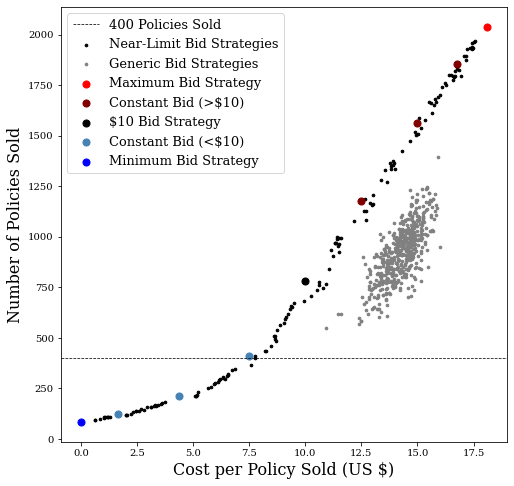

In [295]:
plt.figure(figsize=(8,8))

plt.scatter(NearLim_AdCosts, NearLim_TotSales, color='k', label='Near-Limit Bid Strategies', s=7)
plt.scatter(AdCosts, TotSales, color='0.5', label='Generic Bid Strategies', s=7)

plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

#Include the maxed out bid strategy
AdCost, TotSale = BidStrategyStats( [10.00+4.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='r', label='Maximum Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale = BidStrategyStats( [10.00+3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', label='Constant Bid (>$10)', s=50)
AdCost, TotSale = BidStrategyStats( [10.00+2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)
AdCost, TotSale = BidStrategyStats( [10.00+1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)

#Include the $10 bid strategy 
AdCost, TotSale = BidStrategyStats( [10.00]*35, printout=False )
plt.scatter(AdCost, TotSale, color='k', label='$10 Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale = BidStrategyStats( [10.00-1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', label='Constant Bid (<$10)', s=50)
AdCost, TotSale = BidStrategyStats( [10.00-2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)
AdCost, TotSale = BidStrategyStats( [10.00-3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)

#Include the all minimum bid strategy
AdCost, TotSale = BidStrategyStats( [MinBidVal]*35, printout=False )
plt.scatter(AdCost, TotSale, color='b', label='Minimum Bid Strategy', s=50)

plt.legend(fontsize=13,loc='best')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=16)
plt.ylabel('Number of Policies Sold', fontsize=16)

plt.show()

Thus, if our assumption that changing our bid by \\\$2.50 will shift the ad's rank by 1 is a valid one, then we can obtain 400 expected policy sales at an ad cost of about \\\$7.50 per policy sold. This would be a considerable 25\% savings over the current flat \\\$10 bid strategy. We can now make quantitative estimates for how policy sales will increase or decrease as we change our bidding strategies, particularly for constant bid strategies (shown using the larger and colored points above).

Notably, there seems to be a crisply defined optimal limit shown by the small black points above. Generic bid strategies tend to do worse than this limit (i.e., yield less policies for a chosen cost per sale), as shown by the cloud of gray points produced by randomly selecting bid prices. We can thus offer management the curve of black points as an optimized function from which they can determine how best to proceed based on whether they need to save on ad spending or maximize policy sales.

In [297]:
#Let's see how different that plot looks if we assume that $1.00 shifts in bid will move rank instead of $2.50

#This is the amount (in dollars) that we are assuming will increase a bid's rank placement by 1 spot
RankValue = 1.00

# We'll again assume that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01

PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])

RandomSampleN = 10

AdCosts = []
TotSales = []

def FillTestBids(N, int_low, int_high):
    for i in range(N):
        TestBids = []
        for j in range(35):
            TestBids.append( PossibleBids[np.random.randint(int_low, int_high)] )
        AdCost, TotSale = BidStrategyStats(TestBids, printout=False)
        AdCosts.append(AdCost)
        TotSales.append(TotSale)

#Selective sampling trying to fill out the near-limit space in the plot below
FillTestBids(RandomSampleN, 0, 2)
FillTestBids(RandomSampleN, 1, 3)
FillTestBids(RandomSampleN, 2, 4)
FillTestBids(RandomSampleN, 3, 5)
FillTestBids(RandomSampleN, 4, 6)
FillTestBids(RandomSampleN, 5, 7)
FillTestBids(RandomSampleN, 6, 8)
FillTestBids(RandomSampleN, 7, 9)

FillTestBids(RandomSampleN, 0, 3)
FillTestBids(RandomSampleN, 1, 4)
FillTestBids(RandomSampleN, 2, 5)
FillTestBids(RandomSampleN, 3, 6)
FillTestBids(RandomSampleN, 4, 7)
FillTestBids(RandomSampleN, 5, 8)
FillTestBids(RandomSampleN, 6, 9)

NearLim_AdCosts = AdCosts.copy()
NearLim_TotSales = TotSales.copy()

#Now get a random sample of the whole set of bid options
AdCosts = []
TotSales = []

FillTestBids(50*RandomSampleN, 0, 9)

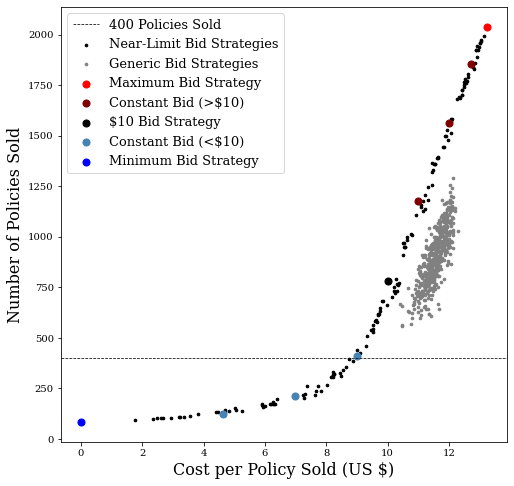

In [298]:
plt.figure(figsize=(8,8))

plt.scatter(NearLim_AdCosts, NearLim_TotSales, color='k', label='Near-Limit Bid Strategies', s=7)
plt.scatter(AdCosts, TotSales, color='0.5', label='Generic Bid Strategies', s=7)

plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

#Include the maxed out bid strategy
AdCost, TotSale = BidStrategyStats( [10.00+4.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='r', label='Maximum Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale = BidStrategyStats( [10.00+3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', label='Constant Bid (>$10)', s=50)
AdCost, TotSale = BidStrategyStats( [10.00+2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)
AdCost, TotSale = BidStrategyStats( [10.00+1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='maroon', s=50)

#Include the $10 bid strategy 
AdCost, TotSale = BidStrategyStats( [10.00]*35, printout=False )
plt.scatter(AdCost, TotSale, color='k', label='$10 Bid Strategy', s=50)

#Include intermediate constant-bid strategies
AdCost, TotSale = BidStrategyStats( [10.00-1.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', label='Constant Bid (<$10)', s=50)
AdCost, TotSale = BidStrategyStats( [10.00-2.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)
AdCost, TotSale = BidStrategyStats( [10.00-3.0*RankValue]*35, printout=False )
plt.scatter(AdCost, TotSale, color='steelblue', s=50)

#Include the all minimum bid strategy
AdCost, TotSale = BidStrategyStats( [MinBidVal]*35, printout=False )
plt.scatter(AdCost, TotSale, color='b', label='Minimum Bid Strategy', s=50)

plt.legend(fontsize=13,loc='best')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=16)
plt.ylabel('Number of Policies Sold', fontsize=16)

plt.show()